### Linked-Chain Toy Model

_Equilibrating toward nonzero value is essential_

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from time import time


rng = np.random.default_rng(seed=int(time()))
mu_mvg, sigma_mvg = 7.5, 0


def gaussian(x, loc, scale):
    return (
        1
        / np.sqrt(2 * np.pi * scale**2)
        * np.exp(-((x - loc) ** 2) / (2 * scale**2))
    )


def gaussian_hit(agents, k, dx, var):
    x = np.arange(agents.size) * dx
    hit = rng.normal(mu_mvg, sigma_mvg) * gaussian(x, loc=k * dx, scale=var * dx)
    if k < agents.size // 2:
        hit[agents.size // 2 :] = 0
    else:
        hit[: agents.size // 2] = 0

    return hit


def feedback_probability(agents):
    _p = np.where(agents > 0, agents, 0) + 1e-5
    return _p / _p.sum()

In [14]:
N = 6
dt = 0.00075
T = 100000
tau_mvg = 0.0045
tau = 0.5
alpha = 0.05

rng = np.random.default_rng(seed=int(time()))

LS, LE, RS, RE = 0, 1, 3, 5
agents = np.array(list(rng.uniform(LS, LE, size=N//2)) + list(rng.uniform(RS, RE, size=N//2)))
pol_t = []

for t in range(T):
    # store value at t
    pol_t.append(agents.copy())

    # get an agent to hit with MVG IF time is right
    # 1/2 factor is for phi in phase field
    if t % int(tau_mvg / dt) == 0:
        k = rng.choice(agents.size, p=feedback_probability(agents))
        # k = rng.choice(agents.size)
        agents += 0.05 * gaussian_hit(agents, k, dx=1, var=5)

    # decay agents
    agents -= dt / tau * (agents - alpha)

pol_t = np.array(pol_t)
ts = np.arange(T) * dt * 8


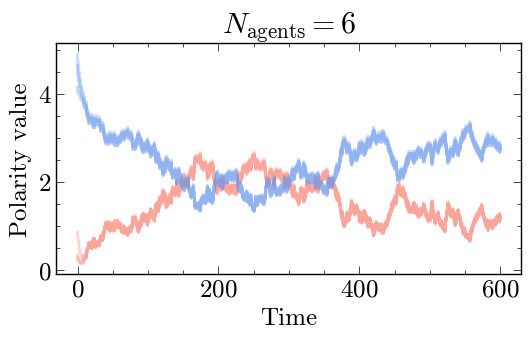

In [15]:
plt.figure(figsize=(6, 3), dpi=100)
for k in range(agents.size):
    if k < agents.size // 2:
        color = "salmon"
        lbl = "left"
    else:
        color = "cornflowerblue"
        lbl = "right"
    plt.plot(ts, pol_t.T[k], c=color, alpha=2 / N)

plt.xlabel("Time")
plt.ylabel("Polarity value")
plt.title(r"$N_\mathrm{agents} = $" + f"{N}")
plt.show()

---

### Linked-Chain Toy Model with Negative Feedback

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from time import time


def Hill_eq(polarity, rate, order):
    q = np.power(polarity, order)
    return q / (rate + q)


def sigmoid(polarity, center, bandwidth):
    return 1 / (1 + np.exp(-(polarity - center) / bandwidth))

In [23]:
N = 60
dt = 0.00075
T = 100000
tau_mvg = 0.0045
tau = 0.5

rng = np.random.default_rng(seed=int(time()))
LS, LE, RS, RE = 1, 3, 1, 3
agents = np.array(list(rng.uniform(LS, LE, size=N//2)) + list(rng.uniform(RS, RE, size=N//2)))
pol_t = []

for t in range(T):
    # store value at t
    pol_t.append(agents.copy())

    # get an agent to hit with MVG IF time is right
    # 1/2 factor is for phi in phase field
    hit = 0
    if t % int(tau_mvg / dt) == 0:
        k = rng.choice(agents.size, p=feedback_probability(agents))
        hit = 0.05 * gaussian_hit(agents, k, dx=1, var=5)

    # update agents
    agents += -dt / tau * agents + hit - dt * Hill_eq(agents, rate=550, order=6)
    # agents += -dt / tau * (agents - alpha) + hit - sigmoid(agents, 0.9, 0.05)


pol_t = np.array(pol_t)
ts = np.arange(T) * dt * 8

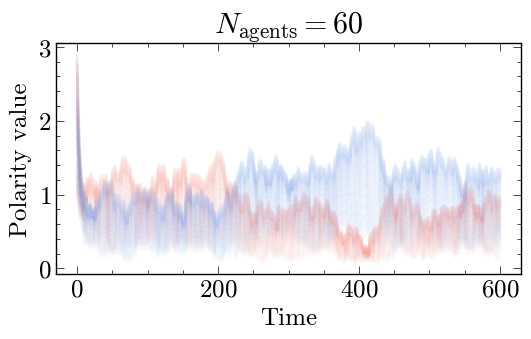

In [24]:
plt.figure(figsize=(6, 3), dpi=100)
for k in range(agents.size):
    if k < agents.size // 2:
        color = "salmon"
        lbl = "left"
    else:
        color = "cornflowerblue"
        lbl = "right"
    plt.plot(ts, pol_t.T[k], c=color, alpha=2 / N)

plt.xlabel("Time")
plt.ylabel("Polarity value")
plt.title(r"$N_\mathrm{agents} = $" + f"{N}")
plt.show()

---

### Static Phase-field Polarity Model

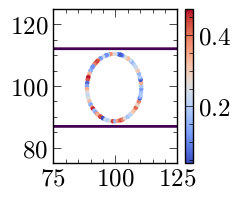

In [69]:
from cell.cell import Cell
from box.sim_box import SimulationBox
from polarity.polarity import *
from helper_functions import helper_functions as hf
from substrate.substrates import Substrate
import yaml, os


im_kwargs = {"origin": "lower", "extent": [0, 50, 0, 50]}
simbox_yaml = yaml.safe_load(open("../_server/sim_data/defaults/configs/grid_id26/simbox.yaml", "r"))
simbox_yaml["substrate"]["sub_sep"] = 0
yaml.dump(simbox_yaml, open("_simbox.yaml", "w"))

cell = Cell(
    "../_server/sim_data/defaults/configs/grid_id26/cell.yaml",
    SimulationBox("_simbox.yaml"),
    seed=int(time()),
)

os.system("rm _simbox.yaml")

grad_x, grad_y, _ = hf.compute_gradients(cell.phi, cell.simbox.dx)
grad_phi = np.array([grad_x, grad_y])
chi = Substrate(200, 50).rectangular()

# x, y
cntr = cell.contour[0][:, ::-1]
p_at_cntr = polarity_at_cntr(cell)
plt.scatter(cntr[:, 0], cntr[:, 1], c=p_at_cntr, cmap="coolwarm", s=5)
plt.colorbar()
plt.contour(chi, levels=[0.5])
plt.ylim((75, 125))
plt.xlim((75, 125))
plt.show()

In [70]:
pol_t = []
mu_mvg = 7.5
sigma_mvg = 0
tau_mvg = 0.0045
dt = 0.00075
T = 5000
tau = 0.5


for t in range(T):
    pol_t.append(polarity_at_cntr(cell))

    patch = 0
    if t % (tau_mvg // dt) == 0:
        mag = cell.rng.normal(loc=mu_mvg, scale=sigma_mvg)
        cntr_probs = cntr_probs_feedback(cell) * cntr_probs_filopodia(
            cell, grad_phi, chi
        )
        cntr_probs = cntr_probs / cntr_probs.sum()
        patch = mag * mvg_patch(cell, cntr_probs)

    # update polarity field
    cell.p_field += patch * cell.phi - (dt / tau * cell.p_field)


pol_t = np.array(pol_t)
ts = np.arange(T) * dt

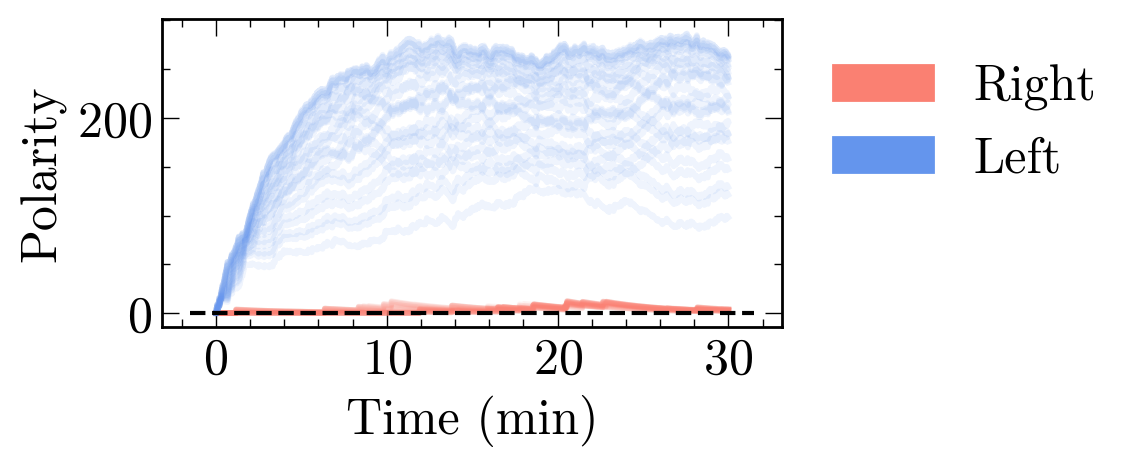

In [71]:
ts = np.arange(T) * dt * 8
agent_indx = np.where((cntr[:, 1] < 108) * (cntr[:, 1] > 90))[0]

plt.figure(figsize=(4, 2), dpi=200)
[
    plt.plot(ts, p, color="salmon", alpha=0.1)
    for p in pol_t.T[np.intersect1d(np.where(cntr[:, 0] > 100)[0], agent_indx)]
]
[
    plt.plot(ts, p, color="cornflowerblue", alpha=0.1)
    for p in pol_t.T[np.intersect1d(np.where(cntr[:, 0] < 100)[0], agent_indx)]
]
plt.hlines(0, *plt.xlim(), lw=1.5, color="black", ls="dashed")
plt.xlabel("Time (min)")
plt.ylabel("Polarity")

import matplotlib.patches as mpatches

legend = [
    mpatches.Patch(color="salmon", label="Right"),
    mpatches.Patch(color="cornflowerblue", label="Left"),
]
plt.legend(handles=legend, bbox_to_anchor=(1.01, 1))
plt.show()
